# Chapter 2 - Time-Series Analysis with Python

The CSV file `spm.csv` was downloaded from the [Our World in Data github repository](https://github.com/owid/owid-datasets/blob/master/datasets) (Air pollution by city - Fouquet and DPCC).

The global temperatures were downloaded from [Datahub](https://datahub.io/core/global-temp).

## Inicialització

### Imports

In [2]:
import datetime

# Tractament de dades
import pandas as pd
import numpy as np

# Funcions estadístiques
from scipy import stats
from statsmodels.tsa import stattools

# Gràfiques
import matplotlib.pyplot as plt
import seaborn as sns

### Alertes estil

In [ ]:
# Activació de les alertes d'estil
%load_ext pycodestyle_magic
%pycodestyle_on

### Lectura de fitxers

In [8]:
# Llegim directament el fitxer des del directori
pollution = pd.read_csv('spm.csv')

## Time Series Analysis TSA Pol·lució

In [9]:
pollution.columns

Index(['Entity', 'Year', 'Smoke (Fouquet and DPCC (2011))',
       'Suspended Particulate Matter (SPM) (Fouquet and DPCC (2011))'],
      dtype='object')

In [10]:
pollution.head()

,Entity,Year,Smoke (Fouquet and DPCC (2011)),Suspended Particulate Matter (SPM) (Fouquet and DPCC (2011))
0,Delhi,1997,NaN,363.0
1,Delhi,1998,NaN,378.0
2,Delhi,1999,NaN,375.0
3,Delhi,2000,NaN,431.0
4,Delhi,2001,NaN,382.0


In [11]:
pollution = pollution.rename(
    columns={
        'Suspended Particulate Matter (SPM) (Fouquet and DPCC (2011))': 'SPM',
        'Entity': 'City',
        'Smoke (Fouquet and DPCC (2011))' : 'Smoke'
    }
)

In [12]:
pollution.dtypes

City      object
Year       int64
Smoke    float64
SPM      float64
dtype: object

In [13]:
pollution['City'].unique()

array(['Delhi', 'London'], dtype=object)

In [14]:
pollution.Year.min(), pollution.Year.max()

(1700, 2016)

In [15]:
# careful: pollution['Year'] = pd.to_datetime(pollution['Year'])
# pandas doesn't handle dates before 1900!
pollution['Year'] = pollution['Year'].apply(
    lambda x: datetime.datetime.strptime(str(x), '%Y')
)

In [16]:
pollution.Year.min(), pollution.Year.max()

(Timestamp('1700-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'))

In [17]:
pollution.isnull().sum() / len(pollution)

City     0.000000
Year     0.000000
Smoke    0.090634
SPM      0.000000
dtype: float64

In [18]:
pollution.describe()

,Smoke,SPM
count,301.000000,331.000000
mean,210.296440,365.970050
std,88.543288,172.512674
min,13.750000,15.000000
25%,168.571429,288.474026
50%,208.214286,375.324675
75%,291.818182,512.609209
max,342.857143,623.376623


Text(0, 0.5, 'Frequency')

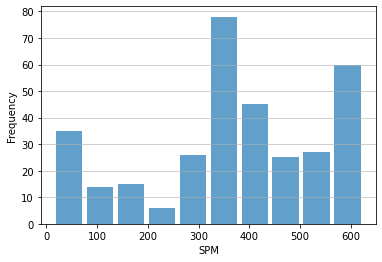

In [19]:
n, bins, patches = plt.hist(
    x=pollution['SPM'], bins='auto',
    alpha=0.7, rwidth=0.85
)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('SPM')
plt.ylabel('Frequency')

Text(336.9714285714286, 0.5, 'SPM')

<Figure size 864x432 with 0 Axes>

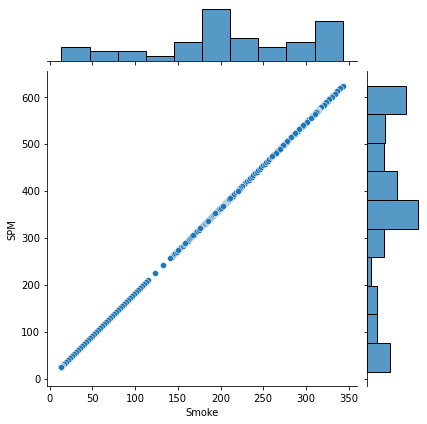

In [21]:
plt.figure(figsize=(12, 6))
sns.jointplot(
    x='Smoke', y='SPM',
    edgecolor='white',
    data=pollution
)
plt.xlabel('Smoke')
plt.ylabel('SPM')

In [22]:
def ignore_nans(a, b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

stats.pearsonr(*ignore_nans(pollution['Smoke'], pollution['SPM']))

(0.9999999999999999, 0.0)

In [23]:
pollution.dtypes

City             object
Year     datetime64[ns]
Smoke           float64
SPM             float64
dtype: object

Text(0, 0.5, 'SPM')

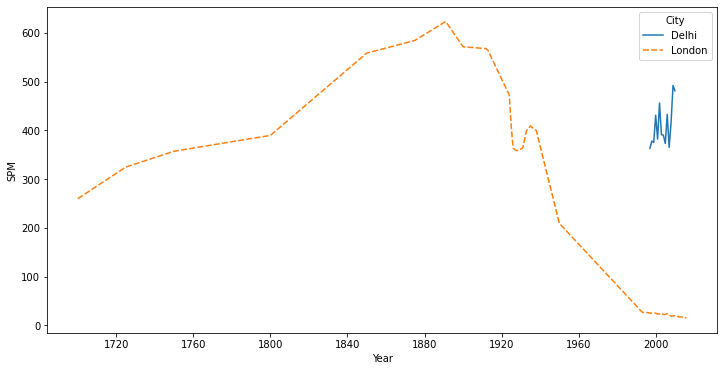

In [24]:
pollution = pollution.pivot("Year", "City", "SPM")
plt.figure(figsize=(12, 6))
sns.lineplot(data=pollution)
plt.ylabel('SPM')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

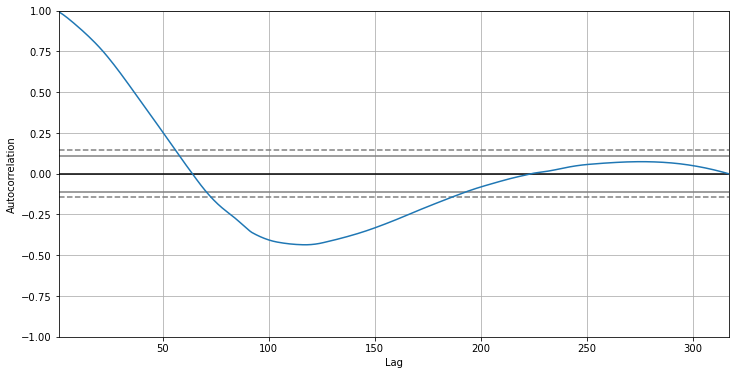

In [25]:
plt.figure(figsize=(12, 6))
pd.plotting.autocorrelation_plot(pollution['London'])

In [26]:
stattools.adfuller(pollution['London'])

(-0.3372164080424312,
 0.9200654843183893,
 13,
 303,
 {'1%': -3.4521175397304784,
  '5%': -2.8711265007266666,
  '10%': -2.571877823851692},
 1684.699266349387)

In [27]:
stats.pearsonr(pollution['London'], pollution.index.values.astype(int))

(-0.0013835903002221515, 0.9804244126807788)

In [28]:
stats.spearmanr(pollution['London'][:180], pollution.index.values.astype(int)[:180])

SpearmanrResult(correlation=0.0003333436217167196, pvalue=0.9964565130656107)

## TSA Temperatures Superfície

### Lectura del fitxer

In [29]:
temperatures = pd.read_csv('monthly_csv.csv')
temperatures.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


### Pretractament

In [31]:
# Convertim a datetime
temperatures['Date'] = pd.to_datetime(temperatures['Date'])

# Pivotem per les dates
temperatures = temperatures.pivot('Date', 'Source', 'Mean')
temperatures.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


### Definició de funcions per tendència i estacionalitat

In [32]:
def fit(X, y, degree=3):
    """
    Ajusta de forma genèrica un polinomi de grau degree a X, y.
    Utilitza la funció polyfit de Numpy
    Args:
        X (list): Valors de les abcises
        y (list): Valors de les ordenades
        degree (int, optional): grau del polinomi a ajustar. Per defecte 3.

    Returns:
        trendpoly (funció) : Funció polinòmica ajustada
    """
    coef = np.polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)


def get_trend(s, degree=3):
    """
    Calcula la tendència en una sèrie
    Args:
        s (pd_series): Sèrie temporal de la que calcularem la tendència
        degree (int, optional): Grau del polinomi per ajustar la tendència. Defaults to 3.

    Returns:
        (pd_series): Sèrie temporal corresponent a la tendència
    """
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)


def get_season(s, yearly_periods=4, degree=3):
    """
    Calcula l'estacionalitat
    Args:
        s (pd_series): Sèrie temporal de la que calcularem l'estacionalitat
        degree (int, optional): Grau del polinomi per ajustar l'estacionalitat. Defaults to 3.

    Returns:
        (pd_series): Sèrie temporal corresponent a l'estacionalitat
    """
    
    # A cada dia assignem el mòdul de la divisió entre el valor de la posició
    # que ocupa en la sèrie i la durada del periode: 365/yearly_periods
    X = [i%(365/yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)

### Càlcul efectiu de la tendència i l'estacionalitat

In [33]:
temperatures['trend'] = get_trend(temperatures['GCAG'])
temperatures['season'] = get_season(temperatures['GCAG'] - 
                                    temperatures['trend'])

### Visualització

Text(0, 0.5, 'Canvi de Temperatura')

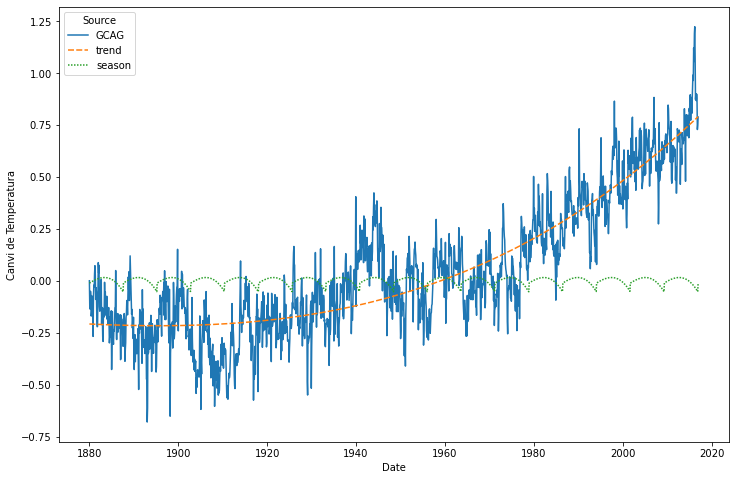

In [34]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=temperatures[['GCAG', 'trend', 'season']])
plt.ylabel('Canvi de Temperatura')